In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-00000-of-00001/train-00000-of-00001.parquet
/kaggle/input/corpus-tag-final-1/corpus_tag_final_1.csv
/kaggle/input/aner-pos-2/aner_pos_2.csv
/kaggle/input/anercorppos/ANERCorp.xlsx
/kaggle/input/corpus-tag-final/corpus_tag_final.csv
/kaggle/input/cc-ar-300-bin-gz/cc.ar.300.bin


In [2]:
!pip install fasttext
!pip install torchinfo
!pip install openpyxl
!pip install pytorch-crf


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchcrf import CRF
from sklearn.model_selection import train_test_split
import fasttext
import torch.nn.functional as F  # Add this import statement to your script
import re

# Load FastText model
ft = fasttext.load_model('/kaggle/input/cc-ar-300-bin-gz/cc.ar.300.bin')

# Load dataset
data = pd.read_csv('/kaggle/input/corpus-tag-final-1/corpus_tag_final_1.csv', usecols=[0, 1], header=None, names=['Word', 'Tag'])

def preprocess_text(text):
    # Your existing preprocessing logic
    if not isinstance(text, str):
        return text
    # Normalize Arabic letters, remove diacritics, punctuation (except periods), and lowercase
    text = re.sub("[أإآ]", "ا", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("[\u064B-\u065F]", "", text)
    text = re.sub(r'[^.\w\s]', '', text)  # Retain periods for sentence splitting
    return text.lower()

data['Word'] = data['Word'].apply(preprocess_text)

# Adjust the method to identify sentence boundaries
# Here, ensure '.' is treated correctly as a sentence delimiter
data['IsPeriod'] = data['Word'] == '.'
data['Sentence#'] = data['IsPeriod'].cumsum()

# Remove rows where 'Word' is just a period, as their only role was to mark sentence boundaries
data = data[data['Word'] != '.']
data = data[data['Tag'] != 'X']

# Now, group by 'Sentence#' to form sentences
sentences = data.groupby('Sentence#')['Word'].apply(list).tolist()
tags = data.groupby('Sentence#')['Tag'].apply(list).tolist()

# Build vocabularies
word_to_ix = {"<PAD>": 0, "<UNK>": 1}
for sentence in sentences:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
tag_to_ix = {"<PAD>": 0}
for tag_seq in tags:
    for tag in tag_seq:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word_to_ix), ft.get_dimension()))
for word, idx in word_to_ix.items():
    if word in ["<PAD>", "<UNK>"] or not isinstance(word, str):
        continue
    embedding_matrix[idx] = ft.get_word_vector(word)
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)


# Dataset class
class NERDataset(Dataset):
    def __init__(self, sentences, tags, word_to_ix, tag_to_ix):
        self.sentences = [[word_to_ix[word] for word in sentence] for sentence in sentences]
        self.tags = [[tag_to_ix[tag] for tag in tag_seq] for tag_seq in tags]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx], dtype=torch.long), torch.tensor(self.tags[idx], dtype=torch.long)

# Collate function for DataLoader
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=word_to_ix["<PAD>"])
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=tag_to_ix["<PAD>"])
    return xx_pad, yy_pad

# Split data and create DataLoader
X_train, X_test, Y_train, Y_test = train_test_split(sentences, tags, test_size=0.1)
train_data = NERDataset(X_train, Y_train, word_to_ix, tag_to_ix)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=pad_collate)

# Define the model
class NERModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, tagset_size, cnn_out_channels=64, kernel_size=3):
        super(NERModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.cnn = nn.Conv1d(in_channels=embedding_matrix.size(1), out_channels=cnn_out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.lstm = nn.LSTM(cnn_out_channels, hidden_dim // 2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, x):
        embeds = self.embedding(x).permute(0, 2, 1)  # Change to (batch, channels, sequence length) for CNN
        cnn_out = F.relu(self.cnn(embeds)).permute(0, 2, 1)  # Apply CNN and then permute back
        lstm_out, _ = self.lstm(cnn_out)
        emissions = self.fc(lstm_out)
        return emissions

    def loss(self, x, y):
        emissions = self.forward(x)
        mask = (x != word_to_ix['<PAD>'])
        return -self.crf(emissions, y, mask=mask)

# Initialize and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NERModel(embedding_matrix.to(device), 256, len(tag_to_ix)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [4]:
# Check the length of sentences and tags to ensure they have been correctly populated
print(f"Number of sentences: {len(sentences)}")
print(f"Number of tag sequences: {len(tags)}")

# Optionally, print a few examples to inspect their content
for i in range(min(5, len(sentences))):
    print(f"Sentence {i+1}: {sentences[i]}")
    print(f"Tags {i+1}: {tags[i]}")
    print("---")


Number of sentences: 235851
Number of tag sequences: 235851
Sentence 1: ['word', 'كتب', 'سالم', 'الرحبي', '', 'تنطلق', 'اليوم', 'الدوره', 'البرامجيه', 'الجديده', 'للتليفزيون', 'والاذاعه', 'وبرنامج', 'الشباب', 'والتي', 'تستمر', 'طوال', 'اشهر', 'ابريل', 'ومايو', 'ويونيو', 'وتحمل', 'في', 'طياتها', 'العديد', 'من', 'البرامج', 'الجديده', 'والفقرات', 'الشيقه', 'التي', 'تتناسب', 'مع', 'اذواق', 'جميع', 'المشاهدين', 'والمستمعين', 'علي', 'حد', 'سواء']
Tags 1: ['POS_Tag', 'VBD', 'NNP', 'DTNNP', 'PUNC', 'VBP', 'DTNN', 'DTNN', 'DTJJ', 'DTJJ', 'NNS', 'NN', 'NN', 'DTNN', 'NNS', 'VBP', 'NN', 'NN', 'NN', 'NNP', 'NNP', 'NNP', 'IN', 'NN', 'DTNN', 'IN', 'DTNN', 'DTJJ', 'NNS', 'DTJJ', 'WP', 'VBP', 'NN', 'NN', 'NOUN_QUANT', 'DTNNS', 'VN', 'IN', 'NN', 'NN']
---
Sentence 2: ['دوره', 'البرامج', 'الحاليه', 'راعي', 'فيها', 'المسؤولون', 'في', 'وزاره', 'الاعلام', 'التنوع', 'والتجديد', 'في', 'البرامج', 'اضافه', 'الي', 'مراعاه', 'اوقات', 'المشاهدين', 'والمستمعين', 'بجميع', 'فئاتهم', 'حيث', 'تم', 'الاعداد', 'المسبق', 

In [5]:
def evaluate(model, data_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct_predictions, total_predictions = 0, 0

    with torch.no_grad():
        for sentences, tags in data_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            loss = model.loss(sentences, tags)
            total_loss += loss.item()

            # Decode the most likely tag sequences with CRF
            outputs = model(sentences)
            predicted_tags = model.crf.decode(outputs)

            # Flatten both true and predicted tags for accuracy calculation
            for i in range(len(tags)):
                true_tags = tags[i].cpu().numpy()
                mask = true_tags != tag_to_ix['<PAD>']  # Ignore PAD tokens
                correct_predictions += np.sum(true_tags[mask] == np.array(predicted_tags[i])[mask])
                total_predictions += np.sum(mask)

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return total_loss / len(data_loader), accuracy


In [6]:
for layer in model.children():
    print(layer)


Embedding(248723, 300)
Conv1d(300, 64, kernel_size=(3,), stride=(1,), padding=(1,))
LSTM(64, 128, batch_first=True, bidirectional=True)
Linear(in_features=256, out_features=33, bias=True)
CRF(num_tags=33)


In [7]:
from torchinfo import summary

# You need to specify input size (including batch size)
# For example, if your input tensor is of shape (batch_size, sequence_length),
# and assuming sequence_length is 100:
input_size = (32, 100)  # Example input size, adjust based on your actual data

# The model needs to be on the device expected for input tensors
model.to(device)

# Get the summary
summary(model, input_size=input_size, dtypes=[torch.long], device=device)


Layer (type:depth-idx)                   Output Shape              Param #
NERModel                                 [32, 100, 33]             1,155
├─Embedding: 1-1                         [32, 100, 300]            (74,616,900)
├─Conv1d: 1-2                            [32, 64, 100]             57,664
├─LSTM: 1-3                              [32, 100, 256]            198,656
├─Linear: 1-4                            [32, 100, 33]             8,481
Total params: 74,882,856
Trainable params: 265,956
Non-trainable params: 74,616,900
Total mult-adds (G): 3.21
Input size (MB): 0.03
Forward/backward pass size (MB): 16.72
Params size (MB): 299.53
Estimated Total Size (MB): 316.27

In [8]:
import torch
from tqdm import tqdm 
 
num_epochs = 5  # Number of epochs to train for

# Move model to the appropriate device
model.to(device)
# Split training data for validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)
train_data = NERDataset(X_train, Y_train, word_to_ix, tag_to_ix)
val_data = NERDataset(X_val, Y_val, word_to_ix, tag_to_ix)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=pad_collate)

training_losses = []
validation_losses = []
validation_accuracy = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for sentences, tags in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        sentences, tags = sentences.to(device), tags.to(device)
        optimizer.zero_grad()
        loss = model.loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    training_losses.append(total_loss / len(train_loader))
    val_loss, val_acc = evaluate(model, val_loader)  # Evaluate on validation set
    validation_losses.append(val_loss)
    validation_accuracy.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_losses[-1]}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc * 100:.2f}%')


Epoch 1/5: 100%|██████████| 5970/5970 [18:57<00:00,  5.25it/s]  
/opt/conda/lib/python3.10/site-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:519.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Epoch 1/5, Training Loss: 628.5622174695908, Validation Loss: 426.8490565081677, Validation Accuracy: 87.35%


Epoch 2/5: 100%|██████████| 5970/5970 [18:55<00:00,  5.26it/s]  


Epoch 2/5, Training Loss: 392.0904284274358, Validation Loss: 369.36513841008565, Validation Accuracy: 88.41%


Epoch 3/5: 100%|██████████| 5970/5970 [18:46<00:00,  5.30it/s] 


Epoch 3/5, Training Loss: 344.55396442253584, Validation Loss: 334.8232264691089, Validation Accuracy: 89.75%


Epoch 4/5: 100%|██████████| 5970/5970 [18:47<00:00,  5.29it/s]  


Epoch 4/5, Training Loss: 316.798244257788, Validation Loss: 314.6718199166907, Validation Accuracy: 90.40%


Epoch 5/5: 100%|██████████| 5970/5970 [18:47<00:00,  5.30it/s]  


Epoch 5/5, Training Loss: 296.62317218620774, Validation Loss: 300.3067838140281, Validation Accuracy: 90.80%


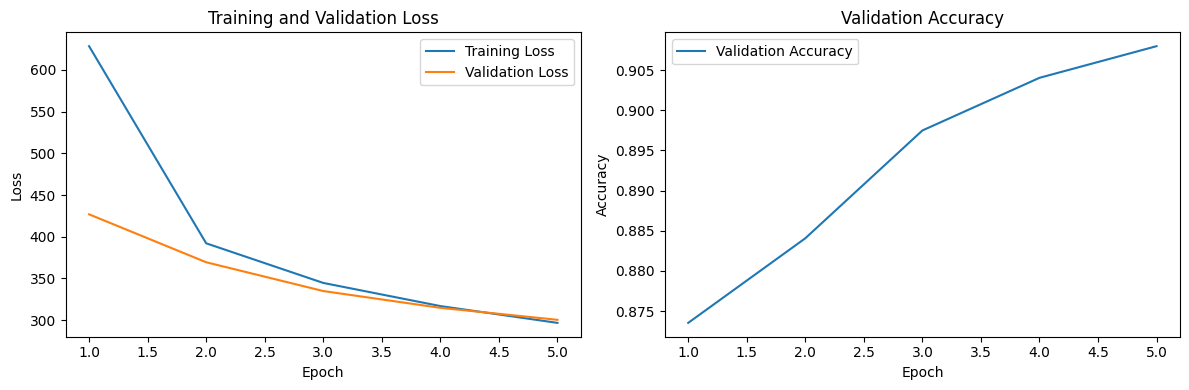

In [9]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
 

In [10]:
val_loss, val_acc = evaluate(model, val_loader)

In [11]:
val_loss 

300.3067838140281

In [12]:
val_acc

0.9079825582969965

In [13]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_and_report(model, data_loader, tag_to_ix):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_true_tags = []
    all_pred_tags = []

    with torch.no_grad():
        for sentences, tags in data_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            loss = model.loss(sentences, tags)
            total_loss += loss.item()

            # Decode the most likely tag sequences with CRF
            outputs = model(sentences)
            predicted_tags = model.crf.decode(outputs)

            # Collect true and predicted tags
            for i in range(len(tags)):
                true_tags = tags[i].cpu().numpy()
                mask = true_tags != tag_to_ix['<PAD>']  # Ignore PAD tokens
                all_true_tags.extend(true_tags[mask])
                all_pred_tags.extend(np.array(predicted_tags[i])[mask])

    # Calculate accuracy
    correct_predictions = np.sum(np.array(all_true_tags) == np.array(all_pred_tags))
    total_predictions = len(all_true_tags)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    # Convert indices to tag names (assuming you have an ix_to_tag dictionary)
    ix_to_tag = {ix: tag for tag, ix in tag_to_ix.items()}
    all_true_tags = [ix_to_tag[ix] for ix in all_true_tags]
    all_pred_tags = [ix_to_tag[ix] for ix in all_pred_tags]

    # Generate classification report
    print(classification_report(all_true_tags, all_pred_tags))

    return total_loss / len(data_loader), accuracy
  

In [14]:
val_loss, val_acc = evaluate_and_report(model, val_loader, tag_to_ix)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc * 100:.2f}%')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     ADJ_NUM       0.88      0.93      0.90      4389
          CC       0.93      0.90      0.91      6627
          CD       0.97      0.97      0.97     14062
          DT       1.00      1.00      1.00     11058
        DTJJ       0.94      0.94      0.94     50894
       DTJJR       0.81      0.85      0.83       658
        DTNN       0.97      0.97      0.97    124597
       DTNNP       0.82      0.83      0.83     11494
      DTNNPS       0.00      0.00      0.00         7
       DTNNS       0.96      0.95      0.95     17587
          IN       0.97      0.94      0.96     85754
          JJ       0.82      0.74      0.78     38691
         JJR       0.58      0.76      0.66      1192
          NN       0.88      0.91      0.90    269287
         NNP       0.83      0.83      0.83    113907
         NNS       0.90      0.84      0.87     17838
  NOUN_QUANT       0.97      0.95      0.96      5314
         PRP       0.97    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
val_loss

300.3067838140281

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, data_loader, tag_to_ix):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_true_tags = []
    all_pred_tags = []

    with torch.no_grad():
        for sentences, tags in data_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            loss = model.loss(sentences, tags)
            total_loss += loss.item()

            # Decode the most likely tag sequences with CRF
            outputs = model(sentences)
            predicted_tags = model.crf.decode(outputs)

            # Collect true and predicted tags
            for i in range(len(tags)):
                true_tags = tags[i].cpu().numpy()
                mask = true_tags != tag_to_ix['<PAD>']  # Ignore PAD tokens
                all_true_tags.extend(true_tags[mask])
                all_pred_tags.extend(np.array(predicted_tags[i])[mask])

    # Calculate accuracy
    accuracy = accuracy_score(all_true_tags, all_pred_tags)

    # Convert indices to tag names (assuming you have an ix_to_tag dictionary)
    ix_to_tag = {ix: tag for tag, ix in tag_to_ix.items()}
    all_true_tags = [ix_to_tag[ix] for ix in all_true_tags]
    all_pred_tags = [ix_to_tag[ix] for ix in all_pred_tags]

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_true_tags, all_pred_tags, average='weighted')

    return total_loss / len(data_loader), accuracy, precision, recall, f1
    
 # Evaluate on validation set
val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, val_loader, tag_to_ix)
    # Print evaluation metrics
print(f'Training Loss: {total_loss / len(train_loader)}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%, Validation Precision: {val_precision * 100:.2f}%, Validation Recall: {val_recall * 100:.2f}%, Validation F1 Score: {val_f1 * 100:.2f}%')

Epoch 5/5, Training Loss: 296.62317218620774, Validation Loss: 300.3067838140281, Validation Accuracy: 90.80%, Validation Precision: 90.80%, Validation Recall: 90.80%, Validation F1 Score: 90.77%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
